In [39]:
import os
import sys
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from google.colab import drive
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import shap
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
def score_distanceM(Xobserve,Yobserve,Xprevu,Yprevu):
  X=(Xobserve-Xprevu)**2
  Y=(Yobserve-Yprevu)**2
  return np.mean(np.sqrt(X+Y))

In [41]:
cd /content/drive/My\ Drive/Colab\ Notebooks/

/content/drive/My Drive/Colab Notebooks


In [42]:
train=pd.read_csv('train_v1.csv')
validation=pd.read_csv('validation_v1.csv')
test=pd.read_csv('test_v1.csv')

In [43]:
train.columns

Index(['nlos_indicator', 't1', 't2', 't3', 't4', 'skew', 'tof', 'tof_skew',
       'range', 'range_skew', 'loc_initiator_x', 'loc_initiator_y',
       'loc_target_x', 'loc_target_y', 'temperature_initiator',
       'temperature_target', 'rssi_request', 'rssi_ack', 'rssi_data',
       'rssi_mean', 'label', 'orientation'],
      dtype='object')

In [44]:
"""
feature_train=train[['nlos_indicator','tof','tof_skew','loc_target_x','loc_target_y',
             'rssi_ack','rssi_data','temperature_initiator','temperature_target','orientation','label']]
xy_train=train[['loc_initiator_x','loc_initiator_y']]
feature_validation=validation[['nlos_indicator','tof','tof_skew','loc_target_x','loc_target_y',
                             'rssi_ack','rssi_data','temperature_initiator','temperature_target','orientation','label']]
xy_validation=validation[['loc_initiator_x','loc_initiator_y']]

feature_test=test[['nlos_indicator','tof','tof_skew','loc_target_x','loc_target_y',
                   'rssi_ack','rssi_data','temperature_initiator','temperature_target','orientation','label']]
xy_test=test[['loc_initiator_x','loc_initiator_y']]
"""
feature_train=train[['nlos_indicator', 't1', 't2', 't3', 't4', 'skew', 'tof', 
                     'tof_skew','range', 'range_skew','loc_target_x', 'loc_target_y', 
                     'temperature_initiator','temperature_target', 'rssi_request', 
                     'rssi_ack', 'rssi_data','rssi_mean', 'label', 'orientation']]

xy_train=train[['loc_initiator_x','loc_initiator_y']]

feature_validation=validation[['nlos_indicator', 't1', 't2', 't3', 't4', 'skew', 'tof',
                               'tof_skew','range', 'range_skew','loc_target_x', 'loc_target_y',
                               'temperature_initiator','temperature_target', 'rssi_request', 
                               'rssi_ack', 'rssi_data','rssi_mean', 'label', 'orientation']]
xy_validation=validation[['loc_initiator_x','loc_initiator_y']]

feature_test=test[['nlos_indicator', 't1', 't2', 't3', 't4', 'skew', 'tof', 'tof_skew','range',
                   'range_skew','loc_target_x', 'loc_target_y', 'temperature_initiator','temperature_target',
                   'rssi_request', 'rssi_ack', 'rssi_data','rssi_mean', 'label', 'orientation']]

xy_test=test[['loc_initiator_x','loc_initiator_y']]

In [48]:
MOR=MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror',colsample_by= 0.01, learning_rate= 0.1, max_depth= 6,
                                          min_child_weight= 0, n_estimators= 1000, sampling_method= 'gradient_based',subsample= 0.75)).fit(feature_train, xy_train)

print('score sur le test  :',MOR.score(feature_test,xy_test))
print('score sur la validation  :',MOR.score(feature_validation,xy_validation))

predict_test=MOR.predict(feature_test)
predict_validation=MOR.predict(feature_validation)
print()
print("RMSE sur le test: % f" %(mean_squared_error(predict_test,xy_test)))
print("RMSE sur la validation: % f" %(mean_squared_error(predict_validation,xy_validation)))
print()
print("MAE sur le test: % f" %(mean_absolute_error(predict_test,xy_test)))
print("MAE sur la validation: % f" %(mean_absolute_error(predict_validation,xy_validation)))
print()

print('score distance test : ',score_distanceM(xy_test.loc_initiator_x, xy_test.loc_initiator_y,predict_test[:,0],predict_test[:,1]))
print('score distance validation : ',score_distanceM(xy_validation.loc_initiator_x, xy_validation.loc_initiator_y,predict_validation[:,0],predict_validation[:,1]))

score sur le test  : 0.9194274569708908
score sur la validation  : 0.9796784704930396

RMSE sur le test:  0.169150
RMSE sur la validation:  0.039431

MAE sur le test:  0.303503
MAE sur la validation:  0.130891

score distance test :  0.46549430276134396
score distance validation :  0.19708772186942475


score sur le test  : 0.8968599271669451
score sur la validation  : 0.9806422399082758

RMSE sur le test:  0.206067
RMSE sur la validation:  0.037658

MAE sur le test:  0.340050
MAE sur la validation:  0.125804

score distance test :  0.5070094530324875
score distance validation :  0.18936452804723763

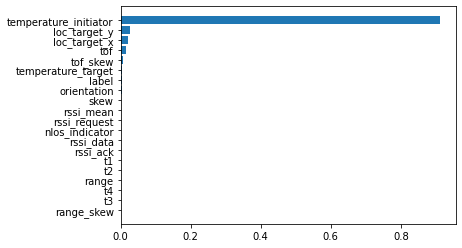

In [52]:
features=MOR.estimators_[0].feature_importances_
#wo_interaction_terms = pd.DataFrame({'importance':features},index=list(X_train.columns())).sort_values('importance', ascending=False)
df_importance=pd.DataFrame({'importance':features ,'variable':feature_train.columns}).sort_values('importance')

plt.barh(range(len(df_importance)), df_importance.importance)
 
# Create names on the x-axis
plt.yticks(range(len(df_importance)), df_importance.variable)
 
# Show graphic
plt.show()

In [63]:
xy_train=train[['loc_initiator_x','loc_initiator_y']]
feature_train=train[list(df_importance[df_importance.importance>0].variable)]

feature_validation=validation[list(df_importance[df_importance.importance>0].variable)]
xy_validation=validation[['loc_initiator_x','loc_initiator_y']]

feature_test=test[list(df_importance[df_importance.importance>0].variable)]

xy_test=test[['loc_initiator_x','loc_initiator_y']]

MOR=MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror',colsample_by= 0.01, learning_rate= 0.1, max_depth= 6,
                                          min_child_weight= 0, n_estimators= 1000, sampling_method= 'gradient_based',subsample= 0.75)).fit(feature_train, xy_train)

print('score sur le test  :',MOR.score(feature_test,xy_test))
print('score sur la validation  :',MOR.score(feature_validation,xy_validation))

predict_test=MOR.predict(feature_test)
predict_validation=MOR.predict(feature_validation)
print()
print("RMSE sur le test: % f" %(mean_squared_error(predict_test,xy_test)))
print("RMSE sur la validation: % f" %(mean_squared_error(predict_validation,xy_validation)))
print()
print("MAE sur le test: % f" %(mean_absolute_error(predict_test,xy_test)))
print("MAE sur la validation: % f" %(mean_absolute_error(predict_validation,xy_validation)))
print()

print('score distance test : ',score_distanceM(xy_test.loc_initiator_x, xy_test.loc_initiator_y,predict_test[:,0],predict_test[:,1]))
print('score distance validation : ',score_distanceM(xy_validation.loc_initiator_x, xy_validation.loc_initiator_y,predict_validation[:,0],predict_validation[:,1]))

score sur le test  : 0.9293225527531914
score sur la validation  : 0.9793343332296047

RMSE sur le test:  0.156421
RMSE sur la validation:  0.040241

MAE sur le test:  0.285750
MAE sur la validation:  0.130817

score distance test :  0.4385468147065683
score distance validation :  0.1972581588944629


score distance test :  0.4385468147065683
score distance validation :  0.1972581588944629
0